# Regression example: Optimization of the marginal likelihood and prediction
1. [Toy data with known additive structure](#dataset)
2. [Training the Laplace-approximated neural additive model (LA-NAM)](#LANAM)
    1. [post-hoc method: fitting and optimizing LA on a standard MLE-trained neural additive model](#posthoc)
    2. [online method: joint optimization of marginal likelihood and prediction](#joint)

In [3]:
import time 
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import matplotlib.pyplot as plt 
import numpy as np
from LANAM.models import LaNAM, NAM, BayesianLinearRegression
from LANAM.config import defaults, nam_defaults
from LANAM.trainer import *
from LANAM.trainer.nam_trainer import *
from LANAM.data import *

from LANAM.utils.plotting import * 
from LANAM.utils.output_filter import OutputFilter
from LANAM.utils.wandb import *

from laplace import Laplace
from laplace import marglik_training as lamt
from laplace.curvature.backpack import BackPackGGN

In [4]:
%reload_ext autoreload
%autoreload 2

## Toy data with known additive structure<a id='dataset'></a>
We firstly set up the data with additive structure $\hat{f}(x_1, x_2, x_3, x_4) = \hat{f}_1(x_1) +\hat{f}_2(x_2) +\hat{f}_3(x_3) +\hat{f}_4(x_4)$ where
$$
\begin{aligned}
\hat{f}_1(x_1) &= 8 (x_1 - \frac{1}{2})^2, \\
\hat{f}_2(x_2) &= \frac{1}{10} \exp [-8x_2 + 4], \\
\hat{f}_3(x_3) &= 5 \exp [-2(2x_3 -1)^2], \\
\hat{f}_4(x_4) &= 0, 
\end{aligned}
$$
Different distributions are used for training and test data: 

$N=400$ noisy observation $\{x_n, y_n\}^N_ {n=1}$ is generated by sampling $x_n$ from normal distribution $\mathcal{N}(0.5, 0.2^2)$ truncated within $[0, 1]$ and generating targets $y_n = \hat{f}(x_n) + \epsilon_n$, where $\epsilon \sim \mathcal{N}(0, 0.7^2)$ is random Gaussian noise.

$N=1000$ test points is generated by sampling $x_n$ uniformly from $U([0, 1]^4)$. 

In [36]:
sigma = 0.7
# training and validation sets
data = load_synthetic_data(sigma=sigma, sampling_type='normal', num_samples=150, x_lims=(0, 1))
train_dl, train_dl_fnn, val_dl, val_dl_fnn = data.train_dataloaders()
in_features = data.in_features
indices = data.train_dl.dataset.indices
X_train, y_train, fnn_train = data.features[indices], data.y[indices], data.feature_targets[indices]

test_data = load_synthetic_data(x_lims=(0, 1), sigma=sigma, sampling_type='uniform',num_samples=1000)
test_dl, test_dl_fnn = test_data.test_dataloaders()
test_samples = test_data.get_test_samples()
X_test, y_test, fnn_test, _ = test_samples

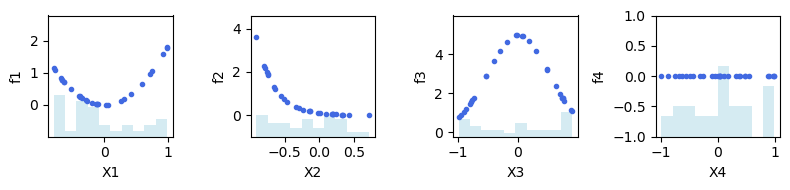

In [37]:
data.plot_dataset()

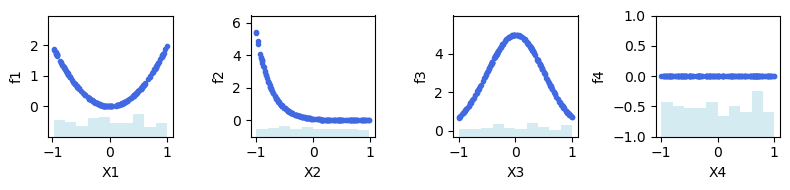

In [38]:
test_data.plot_dataset()

## Training the Laplace-approximated neural additive model (LA-NAM)<a id='LANAM'></a>
### Post-hoc method: fitting and optimizing LA on a standard MLE-trained neural additive model <a id='posthoc'></a>
With the standard MLE-trained neural additive model, we can estimate prior precision and observation noise after training: we fit LA to the training data and minimize the negative log marginal likelihood. 

In [17]:
cfg = defaults()
lanam = LaNAM(config=cfg, name="LA-NAM", in_features=in_features, hessian_structure='kron', subset_of_weights='last_layer')
loss = mle_train(cfg, lanam, train_dl, val_dl)

[EPOCH 1]: loss_train:  19.532, loss_val:  7.660
[EPOCH 51]: loss_train:  0.435, loss_val:  0.852
[EPOCH 101]: loss_train:  0.391, loss_val:  0.722
[EPOCH 151]: loss_train:  0.383, loss_val:  0.729
[EPOCH 201]: loss_train:  0.376, loss_val:  0.712
[EPOCH 251]: loss_train:  0.364, loss_val:  0.688
[EPOCH 301]: loss_train:  0.359, loss_val:  0.707
[EPOCH 351]: loss_train:  0.342, loss_val:  0.712
[EPOCH 401]: loss_train:  0.330, loss_val:  0.698
[EPOCH 451]: loss_train:  0.304, loss_val:  0.698


In [18]:
lanam.fit(loss, train_dl_fnn)

Before optimizing with the marginal likelihood. 

In [19]:
print(f'default observation noise: {lanam.additive_sigma_noise: .4f}')

default observation noise:  2.0000


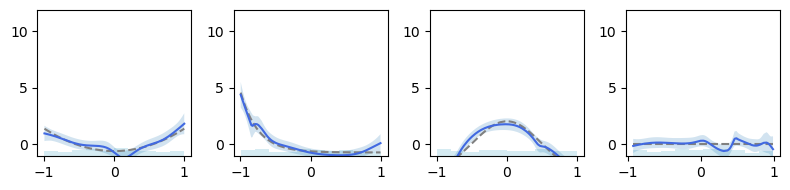

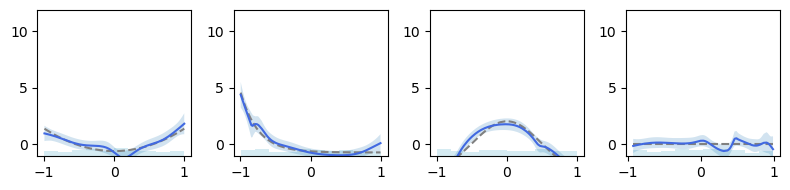

In [20]:
f_mu, f_var, f_mu_fnn, f_var_fnn = lanam.predict(X_test)
plot_recovered_functions(X_test, y_test, fnn_test, f_mu_fnn, f_var_fnn.flatten(start_dim=1))    

Now we initialized `log_prior` and `log_sigma` and minimize the log negative marginal likelihood using Adam.

In [21]:
log_prior, log_sigma = torch.ones(in_features, requires_grad=True), torch.ones(in_features, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(1000):
    hyper_optimizer.zero_grad()
    neg_marglik = - lanam.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [22]:
print(f'found observation noise: {lanam.additive_sigma_noise: .4f}')

found observation noise:  0.5376


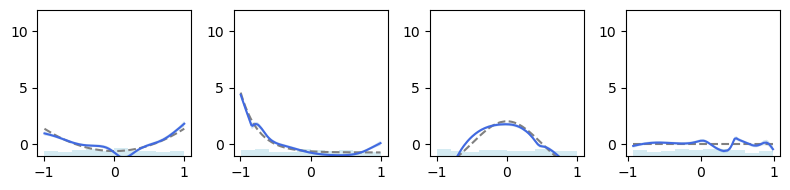

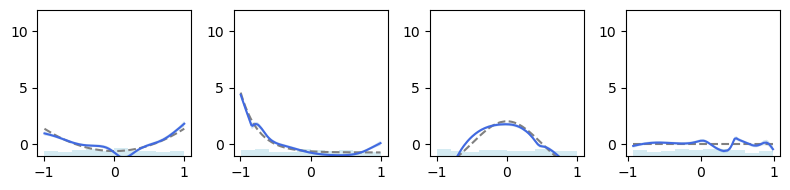

In [24]:
f_mu, f_var, f_mu_fnn, f_var_fnn = lanam.predict(X_test)
plot_recovered_functions(X_test, y_test, fnn_test, f_mu_fnn, f_var_fnn.flatten(start_dim=1))    

### online method: joint optimzation of marginal likelihood and prediction<a id='joint'></a>
Now we optimize LA-NAM jointly with MAP and marginal likelihood maximization. LA-NAM correctly ignores the uninformative feature.

In [25]:
cfg = defaults()
lanam = LaNAM(config=cfg, name="LA-NAM", in_features=in_features, hessian_structure='kron', subset_of_weights='last_layer')

In [47]:
lanam, margs, losses, perfs = marglik_training(lanam, 
                                               train_dl, 
                                               train_dl_fnn, 
                                               test_dl, 
                                               likelihood='regression', 
                                               test_samples=test_samples,
                                               n_epochs=500, 
                                               use_wandb=False, 
                                               optimizer_kwargs={'lr': 1e-2})

[Epoch=100, Train_RMSE:  0.631, Train_R_perp:  0.103, Val_RMSE:  1.145, Val_R_perp:  0.146, n_hypersteps=29]: observed noise= 0.682, prior precision=tensor([0.8492, 0.8078, 0.8382, 0.8350])
[Epoch=200, Train_RMSE:  0.536, Train_R_perp:  0.108, Val_RMSE:  1.218, Val_R_perp:  0.123, n_hypersteps=29]: observed noise= 0.560, prior precision=tensor([0.8294, 0.7530, 0.8998, 0.8938])
[Epoch=300, Train_RMSE:  0.495, Train_R_perp:  0.108, Val_RMSE:  1.262, Val_R_perp:  0.119, n_hypersteps=29]: observed noise= 0.511, prior precision=tensor([0.8425, 0.7118, 0.9360, 0.9175])
[Epoch=400, Train_RMSE:  0.466, Train_R_perp:  0.113, Val_RMSE:  1.295, Val_R_perp:  0.122, n_hypersteps=29]: observed noise= 0.469, prior precision=tensor([0.8537, 0.7233, 0.9754, 0.9392])
[Epoch=500, Train_RMSE:  0.446, Train_R_perp:  0.113, Val_RMSE:  1.329, Val_R_perp:  0.123, n_hypersteps=29]: observed noise= 0.444, prior precision=tensor([0.8771, 0.7258, 0.9980, 0.9605])
MARGLIK: finished training. Recover best model and

In [48]:
print(f'found observation noise: {lanam.additive_sigma_noise: .4f}')

found observation noise:  0.4441


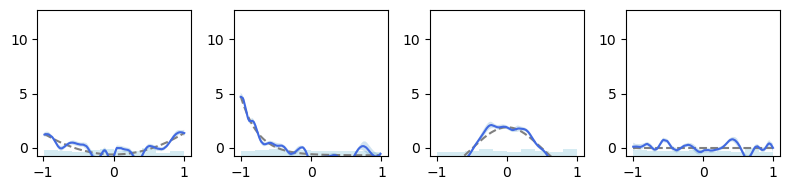

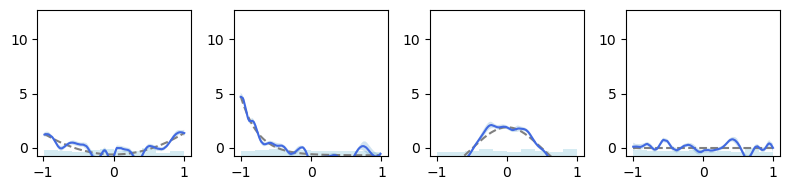

In [49]:
f_mu, f_var, f_mu_fnn, f_var_fnn = lanam.predict(X_test)
plot_recovered_functions(X_test, y_test, fnn_test, f_mu_fnn, f_var_fnn.flatten(start_dim=1))    